<a href="https://colab.research.google.com/github/mohangiri1/Physics/blob/main/ExperimentalPhysics/temperature_dependent_bandgap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here, I will try to explore the temperature dependent bandgap of GaBiAs using model proposed by Mohmad et al. described on his paper https://onlinelibrary.wiley.com/doi/abs/10.1002/pssb.201350311.

On his paper, the temperature dependent bandgap, as he proposes (in equation 5) is:
\begin{equation}
  E(T) = E_0 - \frac{\alpha T^2}{\beta + T} - c(T) k_B T
\end{equation}

Where, c(T) is given by solving a transedental equation
\begin{equation}
  c e^c = ( (\frac{\sigma}{k_B T})^2 -c ) \frac{\tau_r}{\tau_{tr}}e^{(E_0 - E_a)/k_B T}
\end{equation}

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k as k_B
from scipy.constants import e
from scipy.optimize import fsolve

def solve_for_c(T, sigma, Ea, E0, tau_r, tau_tr):
    """
    Solve for c in the transcendental equation:
    c * exp(c) = [(sigma / (k_B * T))**2 - c] * (tau_r / tau_tr) * exp((E0 - Ea) / (k_B * T))
    with 0 < c < (sigma / (k_B * T))**2.

    Parameters:
    - T (float): Temperature in Kelvin.
    - sigma (float): Standard deviation related to localized states.
    - Ea (float): Activation energy for delocalization.
    - E0 (float): Energy at 0 K.
    - tau_r, tau_tr (float): Recombination and transfer times.

    Returns:
    - c (float): Solution for c(T).
    """
    max_c = (sigma / (k_B * T/e))**2  # Upper limit for c

    # Define the equation for c
    def equation(c):
        if c <= 0 or c >= max_c:
            return np.inf  # Return a large penalty for invalid values of c
        lhs = c * np.exp(c)
        # Limit the value of the exponential term to avoid overflow
        exp_term = np.exp(min((E0 - Ea) / (k_B * T/e), 700))  # limit exponent to prevent overflow
        rhs = (max_c - c) * (tau_r / tau_tr) * exp_term
        return lhs - rhs

    # Initial guess for c within the allowed range
    c_initial_guess = min(1.0, max_c * 0.5)
    # Use fsolve with warning suppression
    c_solution = fsolve(equation, c_initial_guess, xtol=1e-6, full_output=True)

    # Check if solution converged; if not, use a fallback value for c
    if c_solution[2] != 1:
        print(f"Warning: No convergence at T={T}. Using fallback value for c.")
        return max_c * 0.5  # Fallback value within valid range
    return c_solution[0][0]

def pl_peak_energy(T, E0, a, b, sigma, Ea, tau_r, tau_tr):
    """
    Calculate the temperature-dependent PL peak energy based on the given parameters.

    Parameters:
    - T (float or array): Temperature in Kelvin.
    - E0 (float): Energy at 0 K.
    - a, b (float): Varshni equation parameters.
    - sigma (float): Standard deviation related to localized states.
    - Ea (float): Activation energy for delocalization.
    - tau_r, tau_tr (float): Recombination and transfer times.

    Returns:
    - E_T (float or array): Temperature-dependent PL peak energy.
    """
    # Varshni term for bandgap reduction
    varshni_term = a * T**2 / (b + T)

    # Calculate c(T) numerically for each T
    c_T = np.array([solve_for_c(temp, sigma, Ea, E0, tau_r, tau_tr) for temp in T])

    # Total energy according to Eq (5)
    E_T = E0 - varshni_term - c_T * k_B * T/e
    return E_T

def pl_peak_energy_varshni(T, E0, a, b):
    """
    Calculate the temperature-dependent PL peak energy based on the given parameters.

    Parameters:
    - T (float or array): Temperature in Kelvin.
    - E0 (float): Energy at 0 K.
    - a, b (float): Varshni equation parameters.

    Returns:
    - E_T (float or array): Temperature-dependent PL peak energy.
    """
    # Varshni term for bandgap reduction
    varshni_term = a * T**2 / (b + T)

    # Total energy according to Eq (5)
    E_T = E0 - varshni_term
    return E_T


Now execute the above defined functions and plot the PL peak data as a function of temperature.

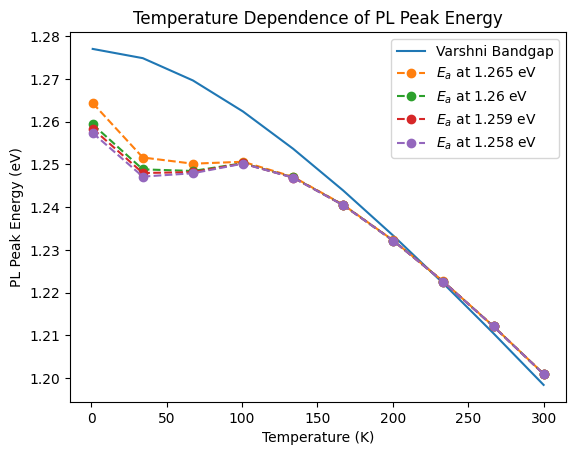

In [8]:
# Example parameters based on provided data
E0 = 1.287  # Peak energy at 0 K in eV for GaAsBi
a = 0.44e-3  # Varshni parameter in eV/K
b = 204      # Varshni parameter in K
sigma = 0.014  # Standard deviation in eV
Ea = 1.265   # Activation energy in eV
Ea1 = 1.26; Ea2 = 1.259; Ea3 = 1.258 # Activation energy in eV
tau_r = 25   # Recombination time (arbitrary unit)
tau_tr = 1   # Transfer time (arbitrary unit)

# Temperature range, avoiding very low values to prevent overflow
T_range = np.linspace(1, 300, 10)

# Calculate PL peak energy across the temperature range
E_T_values = pl_peak_energy(T_range, E0, a, b, sigma, Ea, tau_r, tau_tr)
E_T_values1 = pl_peak_energy(T_range, E0, a, b, sigma, Ea1, tau_r, tau_tr)
E_T_values2 = pl_peak_energy(T_range, E0, a, b, sigma, Ea2, tau_r, tau_tr)
E_T_values3 = pl_peak_energy(T_range, E0, a, b, sigma, Ea3, tau_r, tau_tr)
varshni_bandgap = pl_peak_energy_varshni(T_range, 1.277, 0.44e-3, 204)

# Plot the results
#plt.figure(figsize=(10, 6))
plt.plot(T_range, varshni_bandgap, label='Varshni Bandgap')
plt.plot(T_range, E_T_values,'o--', label=fr'$E_a$ at {Ea} eV')
plt.plot(T_range, E_T_values1,'o--', label=rf'$E_a$ at {Ea1} eV')
plt.plot(T_range, E_T_values2,'o--', label=rf'$E_a$ at {Ea2} eV')
plt.plot(T_range, E_T_values3,'o--', label=rf'$E_a$ at {Ea3} eV')
plt.xlabel("Temperature (K)")
plt.ylabel("PL Peak Energy (eV)")
plt.title("Temperature Dependence of PL Peak Energy")
plt.legend()
#plt.grid(True)
plt.show()